# PDB-CCD TM

## Import Packages and Datasets

In [1]:

import copy
import os
import json
import traceback
import requests
from collections import defaultdict, Counter
import importlib
import contextlib
from glob import glob
import re
import itertools

import numpy as np
from datetime import date
import py3Dmol
import networkx as nx
from pdbeccdutils.core import ccd_reader
import gemmi
import periodictable

import rdkit
from rdkit import Chem
from rdkit import RDLogger
RDLogger.DisableLog('rdApp.*')
from rdkit.Chem.Draw import IPythonConsole
IPythonConsole.molSize = 500, 500

import qcportal
from qcportal.molecules import Molecule
from qcportal.singlepoint import SinglepointDriver
from qcportal.singlepoint import QCSpecification
from qcportal.optimization import OptimizationSpecification
from qcelemental.physical_constants import constants

import scaffold


def view3D(molecule, labels=False):
    """Format 3D view of RDKit molecule

    Args:
        molecule (rdkit.Chem.rdchem.Mol): RDKit molecule to be viewed

    Returns:
        py3Dmol.view: View object.
    """
    mol = Chem.Mol(molecule)
    view = py3Dmol.view(
        data=Chem.MolToMolBlock(mol),  # Convert the RDKit molecule for py3Dmol
        style={"stick": {}, "sphere": {"scale": 0.3}}
    )
    
    # Add atom labels (indices)
    if labels:
        for i, atom in enumerate(mol.GetAtoms()):
            pos = mol.GetConformer().GetAtomPosition(i)
            view.addLabel(str(i), {"position": {"x": pos.x, "y": pos.y, "z": pos.z}, 
                                    "backgroundColor": "white", "backgroundOpacity": 0.2, "fontColor": "black"})

    return view


def topology_from_rdkit(rdkit_molecule):
    """Extract the molecule graph from a RDKit molecule

    Args:
        rdkit_molecule (rdkit.Chem.rdchem.Mol): RDKit molecule

    Returns:
        networkx.Grapth: Graph representation of a molecule
    """

    topology = nx.Graph()
    for atom in rdkit_molecule.GetAtoms():
        # Add the atoms as nodes
        topology.add_node(atom.GetIdx(), symbol=atom.GetSymbol())

        # Add the bonds as edges
        for bonded in atom.GetNeighbors():
            topology.add_edge(atom.GetIdx(), bonded.GetIdx())

    return topology


def is_isomorphic(rdkit_molecule1, rdkit_molecule2):
    """Compare two RDKit molecules and determine if their molecular graphs are the same

    Args:
        rdkit_molecule1 (rdkit.Chem.rdchem.Mol): First RDKit molecule
        rdkit_molecule2 (rdkit.Chem.rdchem.Mol): Second RDKit molecule

    Returns:
        bool: True if the molecular graphs of two molecules are the same.
    """
    def node_match(n1, n2):
        return n1["symbol"] == n2["symbol"]
    
    return nx.is_isomorphic(
        topology_from_rdkit(rdkit_molecule1),
        topology_from_rdkit(rdkit_molecule2),
        node_match=node_match
    )


def first_traceback(keyword="During handling of the above exception"):
    """Exatract the first traceback of an error and return those lines only

    Args:
        keyword (str, optional): Key phase to denote that all other output should be discarded.
        Defaults to "During handling of the above exception".

    Returns:
        str: Lines relating to the first traceback message
    """
    error_msg = traceback.format_exc().split("\n")
    ind = [i for i, x in enumerate(error_msg) if keyword in x]
    ind = ind[0] if len(ind) > 0 else len(error_msg)
    return "\n".join(error_msg[:ind])


def get_entry_cif(pdb_id):
    """
    Downloads and writes PDB entry updated mmCIF to a file and 
    returns the path

    Args:
        pdb_id (str): PDB id of an entry

    Returns:
        str: Path to the downloaded file
    """
    ENTRY_URL = "https://files.rcsb.org/ligands/download/"
    entry_url = os.path.join(ENTRY_URL, f"{pdb_id}.cif")
    response = requests.get(entry_url, stream=True)
    response.raise_for_status()
    with open(f"{pdb_id}.cif", "wb") as fh:
        fh.write(response.content)

    return f"{pdb_id}.cif"


def rdkit_to_smiles( rdmol, isomeric=True, explicit_hydrogens=True, mapped=False):
    """Take an RDKit molecule and output a desired Canonical SMILES string
    
    Based on openff-toolkit.RDKitToolkitWrapper.to_smiles

    Args:
        rdmol (rdkit.Chem.rdchem.Mol): RDKit molecule from which to extract a SMILES string
        isomeric (bool, optional): Choose whether the SMILES should include isomerism. Defaults to True.
        explicit_hydrogens (bool, optional): Choose whether hydrogens are included in SMILES or not. Defaults to True.
        mapped (bool, optional): Choose whether to include atom IDs for mapping purposes. Defaults to False.

    Returns:
        str: Canonical SMILES according to the input options
    """
    if not explicit_hydrogens:
        # remove the hydrogens from the molecule
        rdmol = Chem.RemoveHs(rdmol)
        
    if mapped:
        for atom in rdmol.GetAtoms():
            # the mapping must start from 1, as RDKit uses 0 to represent no mapping.
            atom.SetAtomMapNum(atom.GetIdx() + 1)

    return Chem.MolToSmiles(
        rdmol, isomericSmiles=isomeric, allHsExplicit=explicit_hydrogens, kekuleSmiles=True
    )


def smiles_dict(rdmol):
    """From an RDKit molecule, output a dict with the CMILES types required in OpenFF QCSubmit.

    Args:
        rdmol (rdkit.Chem.rdchem.Mol): RDKit molecule from which to extract CMILES strings.

    Returns:
        dict: Dictionary containing:
        
        - canonical_smiles: isomeric=False, explicit_hydrogens=False, mapped=False
        - canonical_isomeric_smiles: isomeric=True,  explicit_hydrogens=False, mapped=False
        - canonical_explicit_hydrogen_smiles: rdmol, isomeric=False, explicit_hydrogens=True,  mapped=False
        - canonical_isomeric_explicit_hydrogen_smiles: rdmol, isomeric=True,  explicit_hydrogens=True,  mapped=False
        - canonical_isomeric_explicit_hydrogen_mapped_smiles: rdmol, isomeric=True,  explicit_hydrogens=True,  mapped=True

    """
    return {
        "canonical_smiles": rdkit_to_smiles(rdmol, isomeric=False, explicit_hydrogens=False, mapped=False),
        "canonical_isomeric_smiles": rdkit_to_smiles(rdmol, isomeric=True,  explicit_hydrogens=False, mapped=False),
        "canonical_explicit_hydrogen_smiles": rdkit_to_smiles(rdmol, isomeric=False, explicit_hydrogens=True,  mapped=False),
        "canonical_isomeric_explicit_hydrogen_smiles": rdkit_to_smiles(rdmol, isomeric=True,  explicit_hydrogens=True,  mapped=False),
        "canonical_isomeric_explicit_hydrogen_mapped_smiles": rdkit_to_smiles(rdmol, isomeric=True,  explicit_hydrogens=True,  mapped=True),
    }
    
def get_a_bond_length(mol, index=0):
    """Get the length of a bond given the bond index

    Args:
        mol (rdkit.Chem.rdchem.Mol): RDKit molecule
        index (int, optional): Bond index. Defaults to 0.

    Returns:
        float: Bond Length
    """
    conf = mol.GetConformer()
    bond = mol.GetBonds()[index]

    pos1 = conf.GetAtomPosition(bond.GetBeginAtomIdx())
    pos2 = conf.GetAtomPosition(bond.GetEndAtomIdx())

    return np.linalg.norm(
        np.array([pos1.x, pos1.y, pos1.z]) - np.array([pos2.x, pos2.y, pos2.z])
    )


def parse_molecular_formula(formula):
    """Prase molecular formula into a dictionary with elemental keys and the count values.

    Args:
        formula (str): Molecular formula

    Returns:
        dict: Dictionary of elements as keys and count as values
    """
    element_pattern = r'([A-Z][a-z]?)(\d*)'  # Match elements and optional numbers
    element_counts = defaultdict(int)

    for element, count in re.findall(element_pattern, formula):
        element_counts[element] += int(count) if count else 1  # Default count is 1

    return dict(element_counts)

def is_tmc(rdmol, metal_centers=["Mg", "Li", "Fe", "Cu", "Zn", "Pd"]):
    """Determine if RDKit molecule is a transition metal complex of interest

    Args:
        rdmol (rdkit.Chem.rdchem.Mol): RDKit molecule
        metal_centers (list, optional): List of transition metal elements of interest. Defaults to ["Mg", "Li", "Fe", "Cu", "Zn", "Pd"].

    Returns:
        bool: True is the RDKit molecule is a transition metal complex of interest.
    """
    return any([x.GetSymbol() in metal_centers for x in rdmol.GetAtoms()])

def tm_symbol(rdmol, metal_centers=["Mg", "Li", "Fe", "Cu", "Zn", "Pd"]):
    """Return a dictionary with the transition metal center of interst

    Args:
        rdmol (rdkit.Chem.rdchem.Mol): RDKit molecule
        metal_centers (list, optional): List of transition metal centers of interest. Defaults to ["Mg", "Li", "Fe", "Cu", "Zn", "Pd"].

    Returns:
        dict: Dictionary with the transition metal center that is present and the count (defined to be 1).
    """
    return {[x.GetSymbol() for x in rdmol.GetAtoms() if x.GetSymbol() in metal_centers][0]: 1}

def cif_to_rdmol(cif_file, r_cut_h_bond=1.1):
    """Obtain an RDKit molecule from a CIF file

    Args:
        cif_file (str): Filename and path to a CIF file
        r_cut_h_bond (float, optional): Cut off to identify unbonded hydrogen atoms. Defaults to 1.1.

    Returns:
        list[rdkit.Chem.rdchem.Mol]: List of RDKit molecules
    """
    # Parse the CIF file using gemmi
    doc = gemmi.cif.read_file(cif_file)
    block = doc[0] if len(doc) == 1 else doc[1]  # Assuming the second block contains the structure
    cell = gemmi.UnitCell(
        float(re.sub(r'[()]', '', block.find_pair("_cell_length_a")[1])),
        float(re.sub(r'[()]', '', block.find_pair("_cell_length_b")[1])),
        float(re.sub(r'[()]', '', block.find_pair("_cell_length_c")[1])),
        float(re.sub(r'[()]', '', block.find_pair("_cell_angle_alpha")[1])),
        float(re.sub(r'[()]', '', block.find_pair("_cell_angle_beta")[1])),
        float(re.sub(r'[()]', '', block.find_pair("_cell_angle_gamma")[1])),
    )

    # Extract atomic information
    atom_indices = defaultdict(list)
    positions = []
    group = "."
    rdmol = Chem.RWMol()
    atm_sym = block.find_values("_atom_site_type_symbol")
    atm_lab = block.find_values("_atom_site_label")
    atm_fx = block.find_values("_atom_site_fract_x")
    atm_fy = block.find_values("_atom_site_fract_y")
    atm_fz = block.find_values("_atom_site_fract_z")
    atm_fz = block.find_values("_atom_site_fract_z")
    atm_dg = block.find_values('_atom_site_disorder_group') 
    for i, (sym, lab, fx, fy, fz) in enumerate(zip(atm_sym, atm_lab, atm_fx, atm_fy, atm_fz)):
        frac = gemmi.Fractional(
            float(re.sub(r'[()]', '', fx)), 
            float(re.sub(r'[()]', '', fy)),
            float(re.sub(r'[()]', '', fz)),
        )
        # To simplify things, we are only taking the geometry of the first disordered group
        if atm_dg[i] not in [".", group]:
            if group != ".":
                continue
            else:
                group = atm_dg[i]
        
        idx = rdmol.AddAtom(Chem.Atom(sym))  # Add atom to RDKit molecule
        atom_indices[lab].append(idx)
        positions.append(cell.orthogonalize(frac))

    # Add bonds
    bond_labels_1 = block.find_values("_geom_bond_atom_site_label_1")
    bond_labels_2 = block.find_values("_geom_bond_atom_site_label_2")
    for label1, label2 in zip(bond_labels_1, bond_labels_2):
        if label1 in atom_indices and label2 in atom_indices:
            combos = list(itertools.product(atom_indices[label1], atom_indices[label2]))
            for ind1, ind2 in combos:
                try:
                    rdmol.AddBond(ind1, ind2, Chem.BondType.SINGLE)
                    break
                except:
                    pass
    
    # Check for unbonded hydrogens and bond them
    pos_matrix = np.array([[x[0], x[1], x[2]] for x in positions])
    dist = np.linalg.norm(pos_matrix[:, None, :] - pos_matrix[None, :, :], axis=-1)
    for i, atm in enumerate(rdmol.GetAtoms()):
        if "H" in atm.GetSymbol() and atm.GetDegree() == 0:
            short_dists = np.where(np.logical_and(
                dist[i] < r_cut_h_bond,
                dist[i] > 0,
            ))[0]
            for j in short_dists:
                if "H" not in rdmol.GetAtomWithIdx(int(j)).GetSymbol():
                    rdmol.AddBond(int(i), int(j), Chem.BondType.SINGLE)
    
    # Add 3D coordinates
    conf = Chem.Conformer(len(positions))
    for i, (x, y, z) in enumerate(positions):
        conf.SetAtomPosition(i, Chem.rdGeometry.Point3D(x, y, z))
    rdmol.AddConformer(conf)
    
    mols = [rdmol.GetMol()]
    
    return mols


def mol2_to_rdmol(mol2_file):
    """Convert a mol2 file to an rdkit molecule

    Args:
        mol2_file (str): Filename and path to the RDKit molecule

    Returns:
        rdkit.Chem.rdchem.Mol: RDKit molecule
    """
    # Mol2 File
    
    rdmol = Chem.rdmolfiles.MolFromMol2File(mol2_file, sanitize=False, removeHs=False, cleanupSubstructures=False)
    rdmol = Chem.RWMol(rdmol)

    bond_pairs = [sorted([b.GetBeginAtomIdx(), b.GetEndAtomIdx()]) for b in rdmol.GetBonds()]
    bond_types = [b.GetBondType().name for b in rdmol.GetBonds()]
    for btype, indices in [[x, y] for x, y in zip(bond_types, bond_pairs)]:
        if btype == "UNSPECIFIED":
            rdmol.RemoveBond(*indices)
            rdmol.AddBond(*indices, Chem.BondType.SINGLE)
    
    return rdmol


def get_tmc(rdmol):
    """Isolate a transition metal complex (TMC) from a RDKit molecule with several structures.
    
    Structures with less than 4 atoms are discarded. Molecules containing "Tb", "Ho", "Y", or "Dy"
    are assumed to have a net charge of zero. RDKit identifies the charge of all other structures to
    determine the next charge of the TMC.

    Args:
        rdmol (rdkit.Chem.rdchem.Mol): RDKit molecule containing several structures

    Returns:
        rdkit.Chem.rdchem.Mol: RDKit molecule of TMC only
    """

    mols = Chem.rdmolops.GetMolFrags(rdmol, asMols=True, sanitizeFrags=False)
    charge = 0
    for mol in mols:
        if mol.GetNumAtoms() < 4:
            continue
        if is_tmc(mol):
            rdmol = mol
        else:
            if any([a.GetSymbol() in ["Tb", "Ho", "Y", "Dy"] for a in mol.GetAtoms()]):
                continue
            try:
                Chem.SanitizeMol(mol)
            except Exception:
                pass
            charge -= sum(atm.GetFormalCharge() for atm in mol.GetAtoms())


    return rdmol, charge

def check_bohr(mol, d_min=1, d_max=3):
    """Check that the coordinates of an RDKit molecule are in bohr based on the minimum distance.
    
    For reference 1 bohr equates to 0.53 Å.

    Args:
        mol (qcportal.molecules.Molecule): QCElemental molecule
        d_min (float, optional): Minimum allowed distance that the minimum can be to assume that the units are in angstroms. Defaults to 1.
        d_max (float, optional): Maximum allowed distance that the minimum can be to assume that the units are in angstroms. Defaults to 3.

    Returns:
        bool: is_bohr
    """
    
    dist = np.linalg.norm(mol.geometry[None, :, :] - mol.geometry[:, None, :], axis=-1)
    dist[np.where(dist==0)] = np.nan
    min = np.nanmin(dist)
    return np.logical_and(min > d_min, min < d_max)


In [2]:
client = qcportal.PortalClient("https://api.qcarchive.molssi.org:443", cache_dir=".")
from qcfractal.snowflake import FractalSnowflake
snowflake = FractalSnowflake()
client = snowflake.client()

## QC Dataset from PDB CCD

### Get CIFs

In [3]:
chemical_space = "CS-A_subset"
with open(f"{chemical_space}.json", 'r') as f:
    dataset_dict = json.load(f)

print(f"There are {len(dataset_dict)} entries in the dataset {chemical_space}")

There are 46 entries in the dataset CS-A_subset


In [4]:
chemical_space = "charged_organic"
with open(f"{chemical_space}.json", 'r') as f:
    dataset_dict2 = json.load(f)

print(f"There are {len(dataset_dict2)} entries in the dataset {chemical_space}")
dataset_dict.update(dataset_dict2)

There are 16 entries in the dataset charged_organic


In [5]:
cif_path = "cifs_pdb"
os.makedirs(cif_path, exist_ok=True)
os.chdir(cif_path)
for label in dataset_dict:
    code = label.split("_")[1]
    if not os.path.isfile(f"{code}.cif"):
        get_entry_cif(code)
os.chdir("../")

### Get RDKit Molecules

In [6]:
output = {}
for label, mol in dataset_dict.items():
    code = label.split("_")[1]
    metal = list(mol["metals"].keys())[0] if mol["metals"] else None
    rdmol_san = ccd_reader.read_pdb_cif_file(os.path.join(cif_path,f"{code}.cif"), sanitize=True).component.mol
    if rdmol_san.GetNumConformers() > 1:
        rdmol_san.RemoveConformer(0) # Remove openeye coord estimate

    output[label] = mol
    output[label]["rdmol"] = Chem.RWMol(rdmol_san)

print(f"\nWe have {len(output)} left")


We have 62 left


In [7]:
# View all structures to ensure they are viable, all 131 are viable
index = 11
keys = list(output.keys())
print(keys[index])
view3D(output[keys[index]]["rdmol"])
#IPythonConsole.drawMol3D(output[keys[index]]["rdmol"])

data_7BU


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

## QC Dataset from Literature

In [8]:
output_add = defaultdict(dict)

### From CIF Files

**Compound; DOI** \
AN_Li_b_0m_a; 10.1107/S2053229619001396 \
complex5; 10.1021/om0492045 \
complex6; 10.1021/om0492045 \
complex7; 10.1021/om0492045 \
compound1; 10.1107/S0108270113021148 \
compound2; 10.1107/S0108270113021148 \
Pd(IPr)Cl(CH2Cl)(Pp-MeOPh3); 10.1016/j.inoche.2013.06.007 \
Pd(IPr)O2(Pm-tol3); 10.1016/j.inoche.2013.06.007 \
ups3623kg_am34_0m; 10.1016/j.ijbiomac.2023.125847

In [9]:
files = glob("cifs_misc/*.cif")
for i, file in enumerate(files):
    label = ".".join(os.path.split(file)[1].split(".")[:-1])
    try:
        mols = cif_to_rdmol(file)
        charges = {}
        for j,mol in enumerate(mols):
            mol, charge = get_tmc(mol)
            output_add[f"{label}-{j}"]['rdmol'] = mol
            charges[f"{label}-{j}"] = charge
        print(f"Succeeded {i}: {file}")
    except Exception:
        print(f"Failed {i}: {file}")
        print(first_traceback())
        continue
    
    for label, charge in charges.items():
        output_add[label]["metals"] = tm_symbol(output_add[label]['rdmol'])
        if np.abs(charge) > 1:
            raise ValueError("The abs value of charge is greater than 1!")
        else:
            output_add[label]["charge"] = charge
        output_add[label]["molecular_formula"] = "".join([str(y) for a, c in Counter([x.GetSymbol() for x in output_add[label]['rdmol'].GetAtoms()]).items() for y in [a,c]])
        mw = sum(c * getattr(periodictable, a).mass for a, c in parse_molecular_formula(output_add[label]["molecular_formula"]).items())

Succeeded 0: cifs_misc/AN_Li_b_0m_a.cif
Succeeded 1: cifs_misc/compound2.cif
Succeeded 2: cifs_misc/compound1.cif
Succeeded 3: cifs_misc/complex6.cif
Succeeded 4: cifs_misc/Pd(IPr)O2(Pm-tol3).cif
Succeeded 5: cifs_misc/complex7.cif
Succeeded 6: cifs_misc/Pd(IPr)Cl(CH2Cl)(Pp-MeOPh3).cif
Succeeded 7: cifs_misc/complex5.cif
Succeeded 8: cifs_misc/ups3623kg_am34_0m.cif


In [10]:
index = 2

keys = list(output_add.keys())
print(len(output_add[keys[index]]["rdmol"].GetAtoms()), set(x.GetSymbol() for x in output_add[keys[index]]["rdmol"].GetAtoms()))
view3D(output_add[keys[index]]["rdmol"])

83 {'H', 'O', 'Li', 'C', 'S', 'N'}


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

In [11]:
view3D(output["data_FS1"]["rdmol"])

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

### From mol2 files

**Compound; DOI**
2117901; 10.1016/j.molstruc.2022.132506 \
2117902; 10.1016/j.molstruc.2022.132506 \
2117903; 10.1016/j.molstruc.2022.132506 \
1578470; 10.1021/acs.inorgchem.7b03000 \
1578471; 10.1021/acs.inorgchem.7b03000 \
1578472; 10.1021/acs.inorgchem.7b03000 \
1578473; 10.1021/acs.inorgchem.7b03000 \
1578474; 10.1021/acs.inorgchem.7b03000 \
1578475; 10.1021/acs.inorgchem.7b03000 \
1969583; 10.1134/S0022476620090103

In [12]:
files = glob("mol2_misc/*.mol2")
for i, file in enumerate(files):
    label = ".".join(os.path.split(file)[1].split(".")[:-1])
    try:
        mol = mol2_to_rdmol(file)
        mol, charge = get_tmc(mol)
        output_add[f"{label}"]['rdmol'] = mol
        charges[f"{label}"] = charge
        print(f"Succeeded {i}: {file}")
    except Exception:
        print(f"Failed {i}: {file}")
        print(first_traceback())
        continue

    output_add[label]["metals"] = tm_symbol(output_add[label]['rdmol'])
    if np.abs(charge) > 1:
        raise ValueError("The abs value of charge is greater than 1!")
    else:
        output_add[label]["charge"] = charge
    output_add[label]["molecular_formula"] = "".join([str(y) for a, c in Counter([x.GetSymbol() for x in output_add[label]['rdmol'].GetAtoms()]).items() for y in [a,c]])
    mw = sum(c * getattr(periodictable, a).mass for a, c in parse_molecular_formula(output_add[label]["molecular_formula"]).items())

Succeeded 0: mol2_misc/2117901.mol2
Succeeded 1: mol2_misc/1578471.mol2
Succeeded 2: mol2_misc/1578470.mol2
Succeeded 3: mol2_misc/1578473.mol2
Succeeded 4: mol2_misc/1578472.mol2
Succeeded 5: mol2_misc/1578475.mol2
Succeeded 6: mol2_misc/1969583.mol2
Succeeded 7: mol2_misc/2117902.mol2
Succeeded 8: mol2_misc/2117903.mol2
Succeeded 9: mol2_misc/1578474.mol2


In [13]:
index = 6

keys = list(output_add.keys())
print(len(output_add[keys[index]]["rdmol"].GetAtoms()), set(x.GetSymbol() for x in output_add[keys[index]]["rdmol"].GetAtoms()))
view3D(output_add[keys[index]]["rdmol"])

120 {'O', 'H', 'C', 'Cl', 'P', 'Pd', 'N'}


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

## Make QCElemental Molecules

In [14]:
output.update(output_add)
summary = []

# Extract/update data from RDKit molecule, prepare for making QCMolecule
bond_order_dict = {
    "SINGLE": 1,
    "DOUBLE": 2,
    "AROMATIC": 1.5,
    "DATIVE": 0, # this is 1 in rdkit, but it should be zero to determine multiplicity
    "TRIPLE": 3,
}
errors_smiles = defaultdict(list)
qc_input = {}
conformers_dict = defaultdict(list)
for label, mol_dict in output.items():
    
    rdconf = mol_dict['rdmol'].GetConformer()
    conformer = [list(x) for x in rdconf.GetPositions() / constants.bohr2angstroms] # Convert from nm to Bohr (a0)
    symbols = [a.GetSymbol() for a in mol_dict['rdmol'].GetAtoms()]
    connectivity = [(b.GetBeginAtomIdx(), b.GetBeginAtomIdx(), bond_order_dict[b.GetBondType().name]) for b in mol_dict['rdmol'].GetBonds()]
    molecular_weight = sum([a.GetMass() for a in mol_dict['rdmol'].GetAtoms()])

    metal = list(mol_dict['metals'].keys())[0] if mol_dict['metals'] else None
    summary.append((metal, mol_dict['charge'], parse_molecular_formula(mol_dict['molecular_formula']), molecular_weight, mol_dict['rdmol']))

    try:
        identifiers = smiles_dict(mol_dict["rdmol"])
    except Exception as e:
        errors_smiles[str(e)[:39]].append([label, mol_dict["metals"], mol_dict["charge"], first_traceback()]) 
        identifiers = {}
    identifiers["molecular_formula"] = mol_dict["molecular_formula"]

    name = f"{label}"
    conformer_list = [name for name, values in qc_input.items() if is_isomorphic(mol_dict["rdmol"], values["rdmol"])]
    conformers_dict[name] = [name]
    for conf_name in conformer_list:
        if mol_dict["charge"] == qc_input[conf_name]["charge"]:
            conformers_dict[conf_name].append(name)
            conformers_dict[name].append(conf_name)

    if "smiles" in mol_dict:
        info_dict = {
                label: {
                    'smiles': mol_dict['smiles'],
                    'canonical_smiles': mol_dict['canonical_smiles'],
                    'standard_inchi': mol_dict['standard_inchi'],
                    'inchi_key': mol_dict['inchi_key'],
                    "molecular_formula": mol_dict['molecular_formula'],
                }
            }
    else:
        info_dict = {}
    qc_input[name] = {
        "conformers": [conformer],
        "charge": mol_dict["charge"],
        "identifiers": identifiers,
        "symbols": symbols,
        "connectivity": connectivity,
        "extras": {
            "molecular_weight": molecular_weight,
            "metals": mol_dict['metals'],
            "PDB CCD Info": info_dict,
        },
        "rdmol": mol_dict['rdmol'],
    }

print(f"Of the {len(output)} structures, {len(output) - sum(len(value) for key, value in errors_smiles.items())} have smiles strings")

Of the 81 structures, 77 have smiles strings


In [15]:
elements = []
multiplicities = defaultdict(list)
rdkit_pdf_molecules = []
molecules = defaultdict()
errors_misc = defaultdict(dict)
errors_mult = defaultdict(list)
for name, mol_dict in qc_input.items():
    elements.extend(list(set(mol_dict['symbols'])))
    rdkit_pdf_molecules.append(mol_dict["rdmol"])
    multiplicity_list = list(range(1,7)) if mol_dict['extras']['metals'] else [1]
    for multiplicity in multiplicity_list:
        try:
            with open('/dev/null', 'w') as f, contextlib.redirect_stdout(f): # Suppress extraneous print statements
                molecules[f"{name}-m{multiplicity}"] = Molecule(
                    name=f"{name}-m{multiplicity}",
                    symbols=mol_dict['symbols'], 
                    geometry=mol_dict['conformers'],
                    molecular_charge=mol_dict["charge"],
                    molecular_multiplicity=multiplicity,
                    identifiers=mol_dict['identifiers'],
                    connectivity=mol_dict['connectivity'],
                    fix_com=True,
                    fix_orientation=True,
                    fix_symmetry="c1",
                    extras=mol_dict["extras"],
                    comment="Smiles were generated from RDKit Molecule using pdbeccdutils and custom sanitation scripts",
                )
                multiplicities[name].append(multiplicity)
        except Exception as e:
            if "Inconsistent or unspecified chg/mult" in str(e):
                errors_mult[name].append(multiplicity)
            else:
                errors_misc[str(e)[:39]][name] = [mol_dict["extras"], first_traceback()]
    
elements = list(set(elements))
print(sorted(elements))
print(f"Of the {len(dataset_dict)} structures * 5 multiplicities, {len(molecules)} were imported with the requested multiplicities.")

['Br', 'C', 'Cl', 'Cu', 'F', 'Fe', 'H', 'Li', 'Mg', 'N', 'O', 'P', 'Pd', 'S', 'Zn']
Of the 62 structures * 5 multiplicities, 211 were imported with the requested multiplicities.


In [16]:
# Check that all geometries are in bohr
exceptions = ["data_CUL", "data_FS1"] # This check was meant for hydrogen bonds, these compounds don't have those
print(all([check_bohr(mol) for mol in molecules.values() if not any(x in mol.name for x in exceptions)]))

True


In [ ]:
dataset_name = "TM Benchmark Optimization Dataset Step 1 v0.0"
tagline = "Diverse set of conformers for single metal complexes with Pd, Fe, Zn, Cu, Mg, Li and charge of {-1,0,+1}, with some organic molecules for benchmarking purposes at highest level of theory"
description = (
    "This dataset includes single metal complexes with: {'Pd', 'Fe', 'Zn', 'Mg', 'Cu', 'Li'}, and the non-metals: "
    "{'C', 'H', 'P', 'S', 'O', 'N', 'F', 'Cl', 'Br'}, with a complex charge of {-1,0,+1}. Additionally, there are some organic "
    "molecules for benchmarking purposes. These complexes are optimized using SCS-MP3 / aug-cc-pVTZ-DK. The molecular weight "
    "min, mean, and max are 81, 445, and 1026, respectively. There are 81 unique molecules, each tmc is submitted with 3 "
    "different multiplicities to assess the spin state."
)
dataset = client.add_dataset( # https://docs.qcarchive.molssi.org/user_guide/qcportal_reference.html
    "optimization", # collection type
    dataset_name, # Dataset name
    tagline=tagline,
    description=description,
    tags=["openff"],
    provenance={
        "rdkit": rdkit.__version__,
        "pdbeccdutils": importlib.metadata.version("pdbeccdutils"),
        "qcportal": qcportal.__version__,
        "gemmi": gemmi.__version__,
    },
    default_tag="openff",
    metadata={
        "submitter": "Jennifer A Clark",
        "creation_date": date.today(),
        'collection_type': 'OptimizationDataset',
        "long_description": description,
        'long_description_url': f'https://github.com/openforcefield/qca-dataset-submission/tree/master/submissions/2025-03-04-{dataset_name.replace(" ", "-")}',
        "short_description": tagline,
        "dataset_name": dataset_name,
        "elements": elements,
    },
)

In [18]:

spec = OptimizationSpecification(
    program='geometric',
    qc_specification=QCSpecification(
        program='psi4',
        driver=SinglepointDriver.deferred,
        method="scs-mp3",
        basis="aug-cc-pvtz-dk",
        keywords={
            'maxiter': 500, 
            'scf_properties': ['dipole', 'quadrupole', 'wiberg_lowdin_indices', 'mayer_indices', 
                               'lowdin_charges', 'mulliken_charges'],
            'function_kwargs': {'properties': ['dipole_polarizabilities']},
        },
    ),
    keywords={
        'tmax': 0.3,
        'check': 0,
        'qccnv': False,
        'reset': True,
        'trust': 0.1,
        'molcnv': False,
        'enforce': 0.0,
        'epsilon': 1e-05,
        'maxiter': 500,
        'coordsys': 'dlc',
        'constraints': {},
        'convergence_set': 'GAU',
    }, # keywords for geometric
)
name = f"scs-mp3/aug-cc-pvtz-dk"
dataset.add_specification(name=name, specification=spec)

InsertMetadata(error_description=None, errors=[], inserted_idx=[0], existing_idx=[])

In [19]:
for name, mol in molecules.items():
    dataset.add_entry(name, mol)

In [20]:
scaffold.to_json(dataset, compress=True)

## Make Outputs

In [21]:
print("Elements:", sorted(elements))
print("Charges:", sorted(set(x["charge"] for _, x in qc_input.items())))
mw_array = [x["extras"]["molecular_weight"] for _, x in qc_input.items()]
print("Molecular Weight (min mean max):", int(np.min(mw_array)), int(np.mean(mw_array)), int(np.max(mw_array)))
tmp_dict = dict(conformers_dict)
keys = list(tmp_dict.keys())
conformers_dict2 = defaultdict(list)
for name in keys:
    if name not in tmp_dict:
        continue
    conformers_dict2[name] = tmp_dict[name]
    for name2 in tmp_dict[name]:
        if name2 in tmp_dict:
            del tmp_dict[name2]
            
print("Number of Molecules:", len(conformers_dict))
#print("Number of Molecules:", len(conformers_dict2)) # Conformers determined to be isomers not conformers in assess_conformers.ipynb
print("Number of Conformers:", len(conformers_dict))
n_conformers = [len(val) for _, val in conformers_dict2.items()]
#print("Number of conformers (min mean max):", int(np.min(n_conformers)), int(np.mean(n_conformers)), int(np.max(n_conformers)))
print("Number of conformers (min mean max):", 1, 1, 1)
n_multiplicities = np.array([len(x) for _, x in multiplicities.items()])
print("Number of multiplicities per molecule (min mean max):", int(np.min(n_multiplicities)), int(np.mean(n_multiplicities)), int(np.max(n_multiplicities)))


Elements: ['Br', 'C', 'Cl', 'Cu', 'F', 'Fe', 'H', 'Li', 'Mg', 'N', 'O', 'P', 'Pd', 'S', 'Zn']
Charges: [-1, 0, 1]
Molecular Weight (min mean max): 81 445 1026
Number of Molecules: 81
Number of Conformers: 81
Number of conformers (min mean max): 1 1 1
Number of multiplicities per molecule (min mean max): 1 2 3


In [22]:
def write_structure_pdfs(rdkit_molecules, filename="dataset.pdf", columns=4):
    images = []
    for i in range(0, len(rdkit_molecules), 24):
        mol_chunk = rdkit_molecules[i : i + 24]
        for mol in rdkit_molecules[i : i + 24]:
            tmp_mol = copy.deepcopy(mol)
            Chem.AllChem.Compute2DCoords(tmp_mol)
            Chem.AllChem.StraightenDepiction(tmp_mol)
            mol_chunk.append(tmp_mol)

        # now make the image
        image = Chem.Draw.MolsToGridImage(
            mol_chunk,
            molsPerRow=columns,
            subImgSize=(500, 500),
            returnPNG=False,
        )
        # write the pdf to bytes and pass straight to the pdf merger
        images.append(image)

    images[0].save(filename, append_images=images[1:], save_all=True)

In [23]:
write_structure_pdfs(rdkit_pdf_molecules)

## Play with Summary

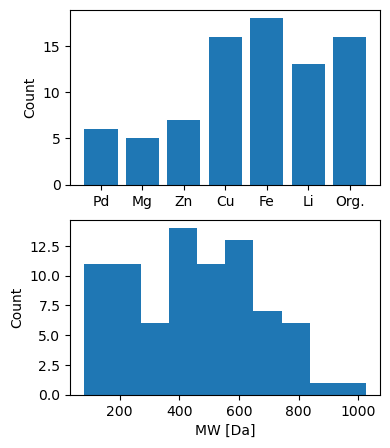

In [24]:
import matplotlib.pyplot as plt

metals = Counter([x[0] for x in summary])
metals["Org."] = metals.pop(None)
labels = list(metals.keys())
values = list(metals.values())

fig, axs = plt.subplots(2, 1, figsize=(4,5))
labels = list(metals.keys())
values = list(metals.values())
axs[0].bar(range(len(values)), values);
axs[0].set_xticks(range(len(values)), labels);
axs[0].set_ylabel("Count")

#axs[1].hist([x[-2] for x in summary]);
axs[1].hist([sum(a.GetMass() for a in x[-1].GetAtoms()) for x in summary]);
axs[1].set_ylabel("Count");
axs[1].set_xlabel("MW [Da]");